In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"astatine243","key":"3ea8af92e68a62d41b1402e2d866f956"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aryashah2k/indian-medicinal-leaves-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/indian-medicinal-leaves-dataset
License(s): CC-BY-NC-SA-4.0
100% 9.00G/9.00G [07:42<00:00, 23.4MB/s]
100% 9.00G/9.00G [07:42<00:00, 20.9MB/s]


In [ ]:
! mkdir ayur

In [ ]:
! unzip /content/indian-medicinal-leaves-dataset.zip -d ayur

Streaming output truncated to the last 5000 lines.
  inflating: ayur/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Avacado/5611.jpg  
  inflating: ayur/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Avacado/5612.jpg  
  inflating: ayur/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Avacado/5613.jpg  
  inflating: ayur/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Avacado/5614.jpg  
  inflating: ayur/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Avacado/5615.jpg  
  inflating: ayur/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Avacado/5616.jpg  
  inflating: ayur/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Avacado/5617.jpg  
  inflating: ayur/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Avacado/5618.jpg  
  inflating: ayur/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset/Avacado/5619.jpg  
  inflating: ayur/Indian Medicinal Leaves Image D

In [ ]:
dataset_dir = '/content/ayur/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset'

**newer code**

In [ ]:
# Install necessary packages (if not already installed)
!pip install opencv-python

# Import necessary libraries
import cv2
import numpy as np
import os
import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Set the dataset directory
dataset_dir = '/content/ayur/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset'

# Verify that the dataset directory exists
if not os.path.exists(dataset_dir):
    print("Dataset directory does not exist. Please check the path.")
else:
    print("Dataset directory found.")

# Prepare the image dataset
classes = sorted(os.listdir(dataset_dir))
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
print(f"Found {len(classes)} classes.")

# Load images and labels
image_dataset = []  # List of (image_path, label) tuples

for cls_name in classes:
    class_dir = os.path.join(dataset_dir, cls_name)
    if not os.path.isdir(class_dir):
        continue
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')):  # Only process image files
            img_path = os.path.join(class_dir, img_name)
            image_dataset.append((img_path, cls_name))  # Store image path and label
        else:
            print(f"Skipping non-image file {img_name}")  # Skip video and other non-image files

print(f"Total images loaded: {len(image_dataset)}")

# Step 1: Multi-View Data Generation
def generate_multi_views(image):
    views = []
    views.append(image)  # Original image

    # Rotations
    for angle in [90, 180, 270]:
        rotated = rotate_image(image, angle)
        views.append(rotated)

    # Lighting Variations
    for brightness in [0.8, 1.2]:
        lit = adjust_brightness(image, brightness)
        views.append(lit)

    # Color Transformations (e.g., saturation changes)
    for saturation in [0.8, 1.2]:
        color_transformed = adjust_saturation(image, saturation)
        views.append(color_transformed)

    return views

def rotate_image(image, angle):
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, matrix, (width, height))
    return rotated

def adjust_brightness(image, brightness_factor):
    return cv2.convertScaleAbs(image, alpha=brightness_factor, beta=0)

def adjust_saturation(image, saturation_factor):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[..., 1] *= saturation_factor
    hsv[..., 1] = np.clip(hsv[..., 1], 0, 255)
    hsv = hsv.astype(np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

# Step 2: Feature Extraction
def extract_features(image):
    # Resize image to a fixed size for HOG descriptor
    image_resized = cv2.resize(image, (64, 128))
    hog = cv2.HOGDescriptor()
    features = hog.compute(image_resized)
    return features.flatten()

# Step 3: Feature Fusion
def fuse_features(view_features, method='concatenation'):
    if method == 'concatenation':
        return np.concatenate(view_features)
    elif method == 'averaging':
        return np.mean(view_features, axis=0)
    elif method == 'weighted':
        weights = np.linspace(1, 0.5, len(view_features))
        weighted_sum = np.sum([w * f for w, f in zip(weights, view_features)], axis=0)
        return weighted_sum / np.sum(weights)
    else:
        raise ValueError("Unknown fusion method")

# Step 4: Classification
def train_classifier(features, labels):
    le = LabelEncoder()
    numerical_labels = le.fit_transform(labels)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    X_train, X_test, y_train, y_test = train_test_split(scaled_features, numerical_labels, test_size=0.2, train_size=0.8, random_state=42)
    classifier = KNeighborsClassifier(n_neighbors=5)
    classifier.fit(X_train, y_train)

    # Evaluation
    accuracy = classifier.score(X_test, y_test)
    print(f"Model Accuracy: {accuracy * 100:.2f}%")

    # Save the classifier and scaler
    joblib.dump(classifier, 'knn_classifier.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    joblib.dump(le, 'label_encoder.pkl')

    return classifier, scaler, le

# Main Algorithm Function
def polyview_leafnet(image_dataset):
    feature_vectors = []
    labels = []

    for idx, (img_path, label) in enumerate(image_dataset):
        # Load the image from path to save memory
        image = cv2.imread(img_path)
        if image is None:
            print(f"Failed to load image {img_path}")
            continue

        # Generate multiple views
        views = generate_multi_views(image)

        # Extract features from each view
        view_features = []
        for view in views:
            features = extract_features(view)
            view_features.append(features)

        # Feature fusion (choose a fusion method)
        fused_features = fuse_features(view_features, method='averaging')  # Use averaging to reduce memory usage

        feature_vectors.append(fused_features)
        labels.append(label)

        # Save features to disk after processing each batch of 100 images to save memory
        if len(feature_vectors) >= 100:
            if os.path.exists('features_labels.pkl'):
                saved_features, saved_labels = joblib.load('features_labels.pkl')
                saved_features.extend(feature_vectors)
                saved_labels.extend(labels)
                joblib.dump((saved_features, saved_labels), 'features_labels.pkl')
            else:
                joblib.dump((feature_vectors, labels), 'features_labels.pkl')
            feature_vectors = []
            labels = []

        # Optional: Progress update
        if (idx + 1) % 100 == 0:
            print(f"Processed {idx + 1}/{len(image_dataset)} images")



    # Load the saved features for training
    if os.path.exists('features_labels.pkl'):
        saved_features, saved_labels = joblib.load('features_labels.pkl')
        # Train the classifier
        classifier, scaler, le = train_classifier(saved_features, saved_labels)
    else:
        print("No features found for training.")
        return None, None, None

    return classifier, scaler, le

# Run the Polyview LeafNet algorithm
classifier, scaler, label_encoder = polyview_leafnet(image_dataset)


Dataset directory found.
Found 80 classes.
Skipping non-image file VID_20190921_120806.mp4
Skipping non-image file VID_20190917_103955.mp4
Skipping non-image file VID_20190917_104022.mp4
Skipping non-image file VID_20190917_103758.mp4
Total images loaded: 6900
Processed 100/6900 images
Processed 200/6900 images
Processed 300/6900 images
Processed 400/6900 images
Processed 500/6900 images
Processed 600/6900 images
Processed 700/6900 images
Processed 800/6900 images
Processed 900/6900 images
Processed 1000/6900 images
Processed 1100/6900 images
Processed 1200/6900 images
Processed 1300/6900 images
Processed 1400/6900 images
Processed 1500/6900 images
Processed 1600/6900 images
Processed 1700/6900 images
Processed 1800/6900 images
Processed 1900/6900 images
Processed 2000/6900 images
Processed 2100/6900 images
Processed 2200/6900 images
Processed 2300/6900 images
Processed 2400/6900 images
Processed 2500/6900 images
Processed 2600/6900 images
Processed 2700/6900 images
Processed 2800/6900

NEW


In [ ]:
# Install necessary packages
!pip install torch torchvision

# Import libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
# Set the dataset directory
dataset_dir = '/content/ayur/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset'

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Custom Dataset Class
class MedicinalLeafDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.images = []
        self.bboxes = []
        self.labels = []

        # Define acceptable image extensions
        self.img_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif']

        for cls_name in self.classes:
            class_dir = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(class_dir):
                # Check if the file is an image
                if self.is_image_file(img_name):
                    img_path = os.path.join(class_dir, img_name)
                    # Placeholder for bounding box; replace with actual annotation loading
                    bbox = [50, 50, 150, 150]  # [x_min, y_min, x_max, y_max]
                    self.images.append(img_path)
                    self.bboxes.append(bbox)
                    self.labels.append(self.class_to_idx[cls_name])

    def is_image_file(self, filename):
        return any(filename.lower().endswith(ext) for ext in self.img_extensions)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        bbox = self.bboxes[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        target = {}
        target['boxes'] = torch.tensor([bbox], dtype=torch.float32)
        target['labels'] = torch.tensor([label], dtype=torch.int64)
        return image, target


In [ ]:
from sklearn.model_selection import train_test_split

# Load dataset
full_dataset = MedicinalLeafDataset(root_dir=dataset_dir, transform=data_transforms)

# Split indices
train_indices, val_indices = train_test_split(list(range(len(full_dataset))), test_size=0.2, random_state=42)

# Subset the datasets
train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)

# Data loaders
def collate_fn(batch):
    images, targets = list(zip(*batch))
    return images, targets

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)


In [ ]:
class AyurBackbone(nn.Module):
    def __init__(self):
        super(AyurBackbone, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),  # [B, 64, 112, 112]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # [B, 64, 56, 56]
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # [B, 128, 56, 56]
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # [B, 128, 28, 28]
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # [B, 256, 28, 28]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((7, 7))  # [B, 256, 7, 7]
        )

    def forward(self, x):
        x = self.conv(x)
        return x


In [ ]:
class AyurTransformer(nn.Module):
    def __init__(self, hidden_dim=256, num_heads=8, num_layers=6):
        super(AyurTransformer, self).__init__()
        self.hidden_dim = hidden_dim
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pos_embedding = nn.Parameter(torch.randn(49, hidden_dim))  # 7x7 patches

    def forward(self, x):
        # x shape: [batch_size, hidden_dim, 7, 7]
        batch_size = x.size(0)
        x = x.flatten(2).permute(2, 0, 1)  # [sequence_length, batch_size, hidden_dim]
        x += self.pos_embedding.unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # [batch_size, sequence_length, hidden_dim]
        x = x.mean(dim=1)  # Global average pooling over sequence length
        return x


In [ ]:
class AyurModel(nn.Module):
    def __init__(self, num_classes):
        super(AyurModel, self).__init__()
        self.backbone = AyurBackbone()
        self.transformer = AyurTransformer()
        self.class_head = nn.Linear(256, num_classes)
        self.bbox_head = nn.Linear(256, 4)

    def forward(self, images):
        features = self.backbone(images)  # [batch_size, hidden_dim, 7, 7]
        transformer_output = self.transformer(features)  # [batch_size, hidden_dim]
        class_logits = self.class_head(transformer_output)  # [batch_size, num_classes]
        bbox_preds = self.bbox_head(transformer_output)  # [batch_size, 4]
        return class_logits, bbox_preds


In [ ]:
classification_loss_fn = nn.CrossEntropyLoss()
bbox_loss_fn = nn.SmoothL1Loss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(full_dataset.classes)
model = AyurModel(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        images = torch.stack(images).to(device)
        labels = torch.cat([t['labels'] for t in targets])
        boxes = torch.cat([t['boxes'] for t in targets])

        optimizer.zero_grad()
        class_logits, bbox_preds = model(images)
        loss_cls = classification_loss_fn(class_logits, labels)
        loss_bbox = bbox_loss_fn(bbox_preds, boxes.squeeze())
        loss = loss_cls + loss_bbox
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

    # Validation after each epoch
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            images = torch.stack(images).to(device)
            labels = torch.cat([t['labels'] for t in targets])
            boxes = torch.cat([t['boxes'] for t in targets])

            class_logits, bbox_preds = model(images)
            loss_cls = classification_loss_fn(class_logits, labels)
            loss_bbox = bbox_loss_fn(bbox_preds, boxes.squeeze())
            loss = loss_cls + loss_bbox
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")


Epoch 1/10: 100%|██████████| 1380/1380 [06:20<00:00,  3.62it/s]


Epoch [1/10], Loss: 76.7015
Validation Loss: 50.3688


Epoch 2/10: 100%|██████████| 1380/1380 [06:20<00:00,  3.62it/s]


Epoch [2/10], Loss: 32.6156
Validation Loss: 11.6961


Epoch 3/10: 100%|██████████| 1380/1380 [06:19<00:00,  3.64it/s]


Epoch [3/10], Loss: 4.6666
Validation Loss: 3.9211


Epoch 4/10: 100%|██████████| 1380/1380 [06:19<00:00,  3.64it/s]


Epoch [4/10], Loss: 3.5471
Validation Loss: 3.4355


Epoch 5/10: 100%|██████████| 1380/1380 [06:19<00:00,  3.63it/s]


Epoch [5/10], Loss: 3.1269
Validation Loss: 2.9550


Epoch 6/10: 100%|██████████| 1380/1380 [06:19<00:00,  3.63it/s]


Epoch [6/10], Loss: 2.7635
Validation Loss: 2.8116


Epoch 7/10: 100%|██████████| 1380/1380 [06:19<00:00,  3.63it/s]


Epoch [7/10], Loss: 2.4432
Validation Loss: 2.6095


Epoch 8/10: 100%|██████████| 1380/1380 [06:20<00:00,  3.63it/s]


Epoch [8/10], Loss: 2.1892
Validation Loss: 2.3081


Epoch 9/10: 100%|██████████| 1380/1380 [06:19<00:00,  3.63it/s]


Epoch [9/10], Loss: 1.9298
Validation Loss: 2.3584


Epoch 10/10: 100%|██████████| 1380/1380 [06:19<00:00,  3.63it/s]


Epoch [10/10], Loss: 1.7200
Validation Loss: 2.1705


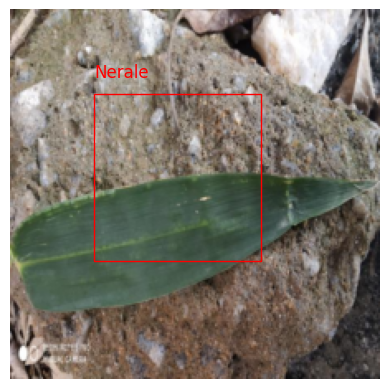

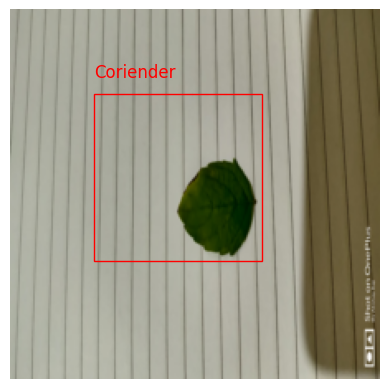

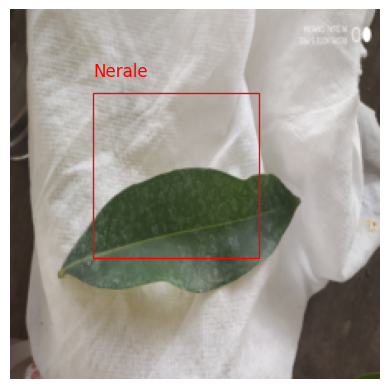

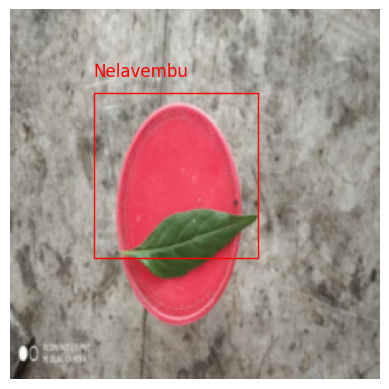

In [ ]:
def visualize_prediction(image, bbox, label, classes):
    image = image.permute(1, 2, 0).cpu().numpy()
    plt.imshow(image)
    x1, y1, x2, y2 = bbox.detach().cpu().numpy()
    width = x2 - x1
    height = y2 - y1
    rect = plt.Rectangle((x1, y1), width, height, fill=False, color='red')
    plt.gca().add_patch(rect)
    plt.text(x1, y1 - 10, classes[label], color='red', fontsize=12)
    plt.axis('off')
    plt.show()

# Get a batch of validation images
model.eval()
images, targets = next(iter(val_loader))
images = [img.to(device) for img in images]
images_stack = torch.stack(images)
class_logits, bbox_preds = model(images_stack)
pred_labels = torch.argmax(class_logits, dim=1)
pred_boxes = bbox_preds

for i in range(len(images)):
    visualize_prediction(images[i].cpu(), pred_boxes[i], pred_labels[i], full_dataset.classes)


Evaluating: 100%|██████████| 345/345 [01:28<00:00,  3.89it/s]


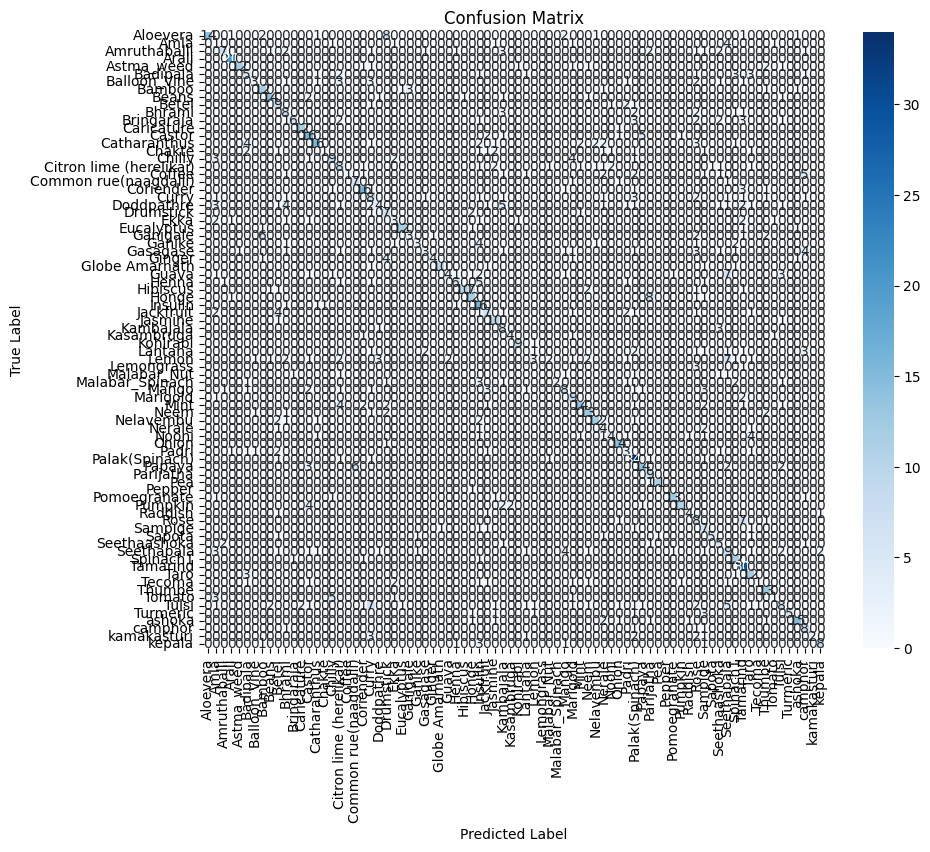

Classification Report:
                         precision    recall  f1-score   support

               Aloevera       1.00      0.45      0.62        31
                   Amla       0.05      0.10      0.06        10
           Amruthaballi       0.64      0.30      0.41        23
                  Arali       0.83      1.00      0.91        20
             Astma_weed       0.92      0.60      0.73        20
               Badipala       0.28      0.28      0.28        18
           Balloon_Vine       0.50      0.19      0.27        16
                 Bamboo       0.52      0.63      0.57        19
                  Beans       0.74      0.67      0.70        21
                  Betel       0.35      0.64      0.45        14
                 Bhrami       0.30      0.47      0.36        17
             Bringaraja       0.75      0.29      0.41        21
             Caricature       0.86      0.92      0.89        13
                 Castor       0.47      0.62      0.53        26
 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_classification(model, dataloader, device, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Evaluating"):
            images = [img.to(device) for img in images]
            images_stack = torch.stack(images)
            class_logits, _ = model(images_stack)
            preds = torch.argmax(class_logits, dim=1).cpu().numpy()
            labels = torch.cat([t['labels'] for t in targets]).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    report = classification_report(all_labels, all_preds, target_names=classes)
    print("Classification Report:")
    print(report)

# Call the function
evaluate_classification(model, val_loader, device, full_dataset.classes)


new 2

Epoch 1/10: 100%|██████████| 173/173 [05:30<00:00,  1.91s/it]


Epoch [1/10], Loss: 4.3544
Validation Loss: 4.3603


Epoch 2/10: 100%|██████████| 173/173 [05:30<00:00,  1.91s/it]


Epoch [2/10], Loss: 4.3194
Validation Loss: 4.2926


Epoch 3/10: 100%|██████████| 173/173 [05:31<00:00,  1.92s/it]


Epoch [3/10], Loss: 4.2044
Validation Loss: 4.2059


Epoch 4/10: 100%|██████████| 173/173 [05:31<00:00,  1.91s/it]


Epoch [4/10], Loss: 4.0567
Validation Loss: 4.0236


Epoch 5/10: 100%|██████████| 173/173 [05:31<00:00,  1.92s/it]


Epoch [5/10], Loss: 3.9801
Validation Loss: 4.0045


Epoch 6/10: 100%|██████████| 173/173 [05:30<00:00,  1.91s/it]


Epoch [6/10], Loss: 3.9361
Validation Loss: 3.9774


Epoch 7/10: 100%|██████████| 173/173 [05:30<00:00,  1.91s/it]


Epoch [7/10], Loss: 3.8961
Validation Loss: 3.8736


Epoch 8/10: 100%|██████████| 173/173 [05:32<00:00,  1.92s/it]


Epoch [8/10], Loss: 3.8576
Validation Loss: 3.8996


Epoch 9/10: 100%|██████████| 173/173 [05:30<00:00,  1.91s/it]


Epoch [9/10], Loss: 3.8310
Validation Loss: 3.8369


Epoch 10/10: 100%|██████████| 173/173 [05:31<00:00,  1.92s/it]


Epoch [10/10], Loss: 3.8073
Validation Loss: 3.8120


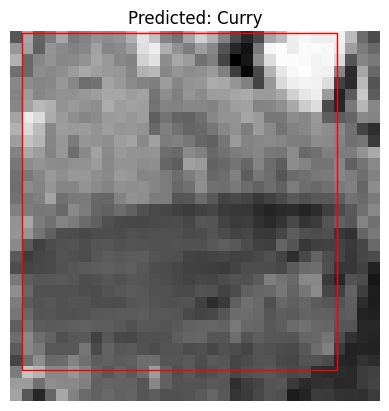

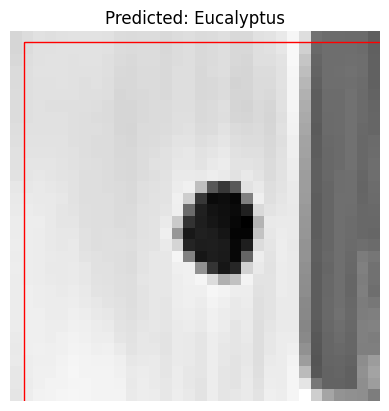

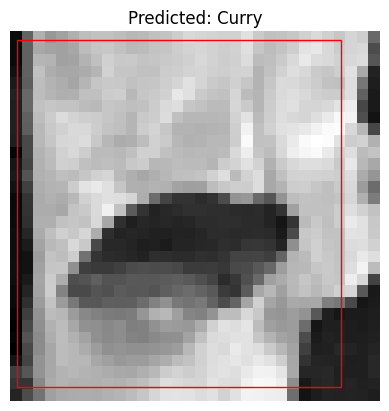

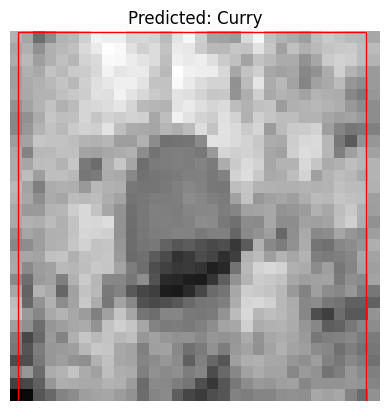

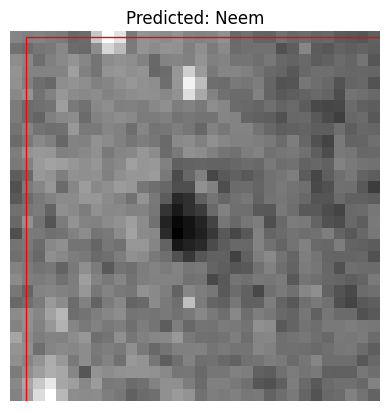

In [ ]:
# Install necessary packages (if not already installed)
!pip install torch torchvision

# Import libraries
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set the dataset directory
dataset_dir = '/content/ayur/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset'

# Define custom transforms (if any)
def custom_transform(image):
    # Resize image to 32x32 and flatten
    image = image.resize((32, 32))
    image = image.convert('L')  # Convert to grayscale
    image_array = np.array(image)
    image_array = image_array.flatten().astype(np.float32) / 255.0  # Normalize pixel values
    return torch.tensor(image_array)

# Custom Dataset Class
class MedicinalLeafDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.samples = []

        # Define acceptable image extensions
        self.img_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif']

        for cls_name in self.classes:
            class_dir = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(class_dir):
                # Check if the file is an image
                if self.is_image_file(img_name):
                    img_path = os.path.join(class_dir, img_name)
                    label = self.class_to_idx[cls_name]
                    self.samples.append((img_path, label))

    def is_image_file(self, filename):
        return any(filename.lower().endswith(ext) for ext in self.img_extensions)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        if self.transform:
            features = self.transform(image)
        else:
            features = np.array(image).astype(np.float32).flatten() / 255.0  # Default flattening
            features = torch.tensor(features)
        # Placeholder bounding box (normalized coordinates)
        bbox = torch.tensor([0.0, 0.0, 1.0, 1.0], dtype=torch.float32)
        return features, {'labels': torch.tensor(label, dtype=torch.long), 'boxes': bbox}

# Load dataset
full_dataset = MedicinalLeafDataset(root_dir=dataset_dir, transform=custom_transform)

# Split dataset into training and validation sets
from sklearn.model_selection import train_test_split

train_indices, val_indices = train_test_split(list(range(len(full_dataset))), test_size=0.2, random_state=42)

train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)

# Data loaders
def collate_fn(batch):
    features, targets = list(zip(*batch))
    features = torch.stack(features)
    labels = torch.tensor([t['labels'] for t in targets], dtype=torch.long)
    boxes = torch.stack([t['boxes'] for t in targets])
    targets = {'labels': labels, 'boxes': boxes}
    return features, targets

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Define the model
class ayurleafModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BasicFCModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.class_head = nn.Linear(128, num_classes)
        self.bbox_head = nn.Linear(128, 4)  # For bounding box regression

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        class_logits = self.class_head(x)
        bbox_preds = self.bbox_head(x)
        return class_logits, bbox_preds

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 32 * 32  # Since images are resized to 32x32 and flattened
num_classes = len(full_dataset.classes)
model = ayurleafModel(input_size=input_size, num_classes=num_classes).to(device)

# Define loss functions and optimizer
classification_loss_fn = nn.CrossEntropyLoss()
bbox_loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for features, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        features = features.to(device)
        labels = targets['labels'].to(device)
        boxes = targets['boxes'].to(device)

        optimizer.zero_grad()
        class_logits, bbox_preds = model(features)
        loss_cls = classification_loss_fn(class_logits, labels)
        loss_bbox = bbox_loss_fn(bbox_preds, boxes)
        loss = loss_cls + loss_bbox
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for features, targets in val_loader:
            features = features.to(device)
            labels = targets['labels'].to(device)
            boxes = targets['boxes'].to(device)

            class_logits, bbox_preds = model(features)
            loss_cls = classification_loss_fn(class_logits, labels)
            loss_bbox = bbox_loss_fn(bbox_preds, boxes)
            loss = loss_cls + loss_bbox
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

# Inference and Visualization
def visualize_prediction(image_tensor, pred_bbox, pred_label, classes):
    # Reshape the image tensor back to 32x32
    image_array = image_tensor.cpu().numpy().reshape(32, 32)
    plt.imshow(image_array, cmap='gray')
    # Since images are resized to 32x32, bounding boxes are in normalized coordinates
    x1, y1, x2, y2 = pred_bbox.detach().cpu().numpy()
    x1 *= 32
    y1 *= 32
    x2 *= 32
    y2 *= 32
    width = x2 - x1
    height = y2 - y1
    rect = plt.Rectangle((x1, y1), width, height, fill=False, color='red')
    plt.gca().add_patch(rect)
    plt.title(f"Predicted: {classes[pred_label]}")
    plt.axis('off')
    plt.show()

# Get a batch of validation images
model.eval()
features, targets = next(iter(val_loader))
features = features.to(device)
class_logits, bbox_preds = model(features)
pred_labels = torch.argmax(class_logits, dim=1)
pred_boxes = bbox_preds

for i in range(5):  # Visualize first 5 images
    visualize_prediction(features[i].cpu(), pred_boxes[i], pred_labels[i].item(), full_dataset.classes)

# Saving the model
torch.save(model.state_dict(), 'basic_fc_object_detection_model.pth')


old

In [ ]:
img_size = (224, 224)
batch_size = 128
epochs = 20

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
dataset_dir = '/content/ayur/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset'
base_dir = '/content/ayur/split_dataset'
train_dir = f"{base_dir}/train"
validation_dir = f"{base_dir}/validation"
test_dir = f"{base_dir}/test"


In [ ]:
if not os.path.exists(base_dir):
    os.makedirs(base_dir)
    os.makedirs(train_dir)
    os.makedirs(validation_dir)
    os.makedirs(test_dir)

    # Split dataset into train, validation, and test sets
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg'))]  # Ensure only image files are included
            train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
            train_images, val_images = train_test_split(train_images, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

            # Create class directories in train, validation, and test sets
            os.makedirs(os.path.join(train_dir, class_name))
            os.makedirs(os.path.join(validation_dir, class_name))
            os.makedirs(os.path.join(test_dir, class_name))

            # Copy images to respective directories
            for img in train_images:
                shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name))
            for img in val_images:
                shutil.copy(os.path.join(class_path, img), os.path.join(validation_dir, class_name))
            for img in test_images:
                shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name))


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

if validation_generator.samples == 0:
    print("Warning: Validation directory is empty or does not contain valid image files.")
    validation_generator = None

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 0 images belonging to 0 classes.


FileNotFoundError: [Errno 2] No such file or directory: '/content/ayur/split_dataset/validation'

In [ ]:
"from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
efficient_net = EfficientNetB0(include_top=False, input_shape=img_size + (3,), pooling='avg')

# Train EfficientNet model
inputs = layers.Input(shape=img_size + (3,))
efficient_features = efficient_net(inputs)
x = layers.BatchNormalization()(efficient_features)
x = layers.Dense(512, activation='swish')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='swish')(x)
x = layers.Dropout(0.3)(x)
efficient_outputs = layers.Dense(train_generator.num_classes, activation='softmax')(x)

efficient_model = models.Model(inputs=inputs, outputs=efficient_outputs)
efficient_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train EfficientNet model
history_efficient = efficient_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0300 - loss: 4.5210

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.0302 - loss: 4.5191 - val_accuracy: 0.0136 - val_loss: 4.3777
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.2276 - loss: 3.3624 - val_accuracy: 0.0172 - val_loss: 4.3866
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.4482 - loss: 2.3931 - val_accuracy: 0.0336 - val_loss: 4.4328
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.6291 - loss: 1.5542 - val_accuracy: 0.2105 - val_loss: 3.4626
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.7191 - loss: 1.0972 - val_accuracy: 0.5190 - val_loss: 1.9599
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.7891 - loss: 0.8025 - val_accuracy: 0.6908 - val_loss: 1.1682
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.8474 - loss: 0.6018 - val_accuracy: 0.7903 - val_loss: 0.7795
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.8725 - loss: 0.4624 - val_accuracy: 0.851

In [ ]:
efficient_model.save('/content/drive/My Drive/efficientnet_model.h5')


In [ ]:
efficient_model.save('/content/drive/My Drive/efficientnet_model.keras')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

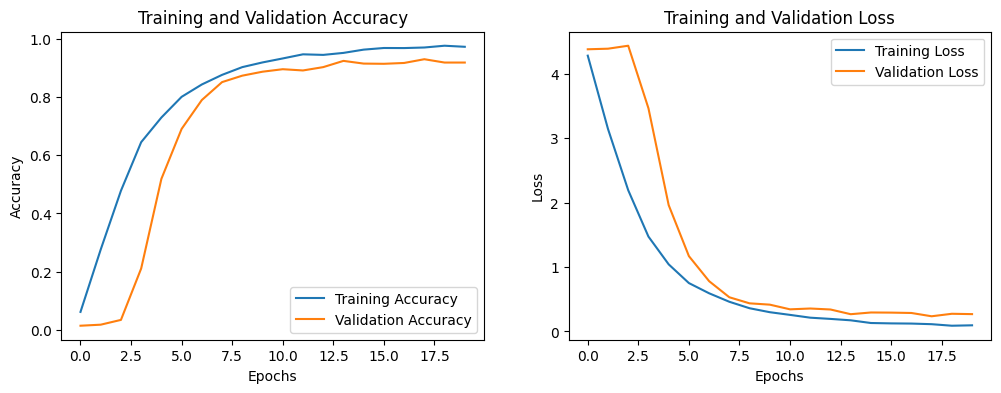

45/45 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step


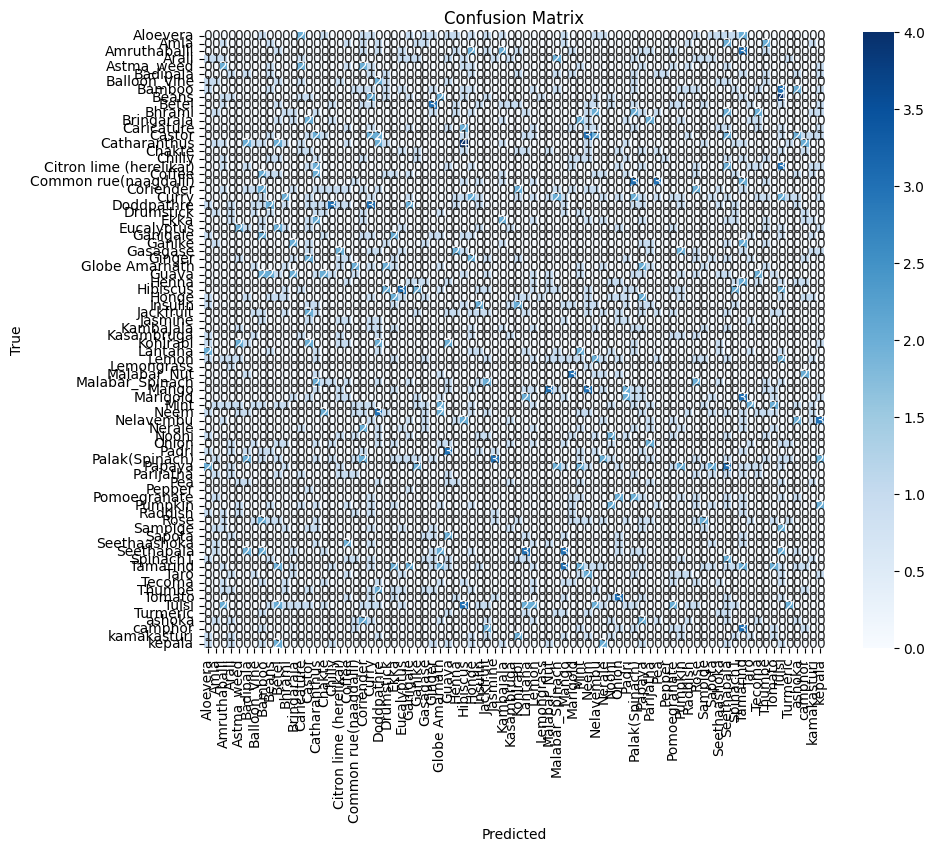

Classification Report:
                         precision    recall  f1-score   support

               Aloevera       0.00      0.00      0.00        24
                   Amla       0.00      0.00      0.00        14
           Amruthaballi       0.00      0.00      0.00        19
                  Arali       0.00      0.00      0.00        18
             Astma_weed       0.00      0.00      0.00        17
               Badipala       0.06      0.06      0.06        16
           Balloon_Vine       0.00      0.00      0.00        13
                 Bamboo       0.00      0.00      0.00        24
                  Beans       0.00      0.00      0.00        20
                  Betel       0.04      0.04      0.04        23
                 Bhrami       0.06      0.05      0.05        21
             Bringaraja       0.08      0.07      0.07        15
             Caricature       0.00      0.00      0.00        16
                 Castor       0.04      0.04      0.04        26
 

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_efficient.history['accuracy'], label='Training Accuracy')
plt.plot(history_efficient.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_efficient.history['loss'], label='Training Loss')
plt.plot(history_efficient.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

# Confusion matrix and classification report
y_pred = np.argmax(efficient_model.predict(test_generator, verbose=1), axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print('Classification Report:')
print(report)

In [ ]:
test_loss_efficient, test_accuracy_efficient = efficient_model.evaluate(test_generator)
print(f"EfficientNet Test Accuracy: {test_accuracy_efficient * 100:.2f}%")

45/45 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9416 - loss: 0.2047
EfficientNet Test Accuracy: 93.35%


In [ ]:
hybrid_model = tf.keras.models.load_model('/content/drive/My Drive/hybrid_model.keras')

# Fine-tune the loaded model using another algorithm
# Unfreeze some layers in the base model for fine-tuning
for layer in hybrid_model.layers:
    layer.trainable = True

# Compile the model with a different optimizer
hybrid_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model further
history_fine_tune = hybrid_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

NameError: name 'tf' is not defined